This is the setup for a standard MRF with inference

Things to discuss:

1. Type of factor: Discrete vs. Continuous 
2. Type of inference: Variable Elimination vs. Belief Propogation
3. How to calculate phi using co-occurrences?

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import VariableElimination, BeliefPropagation
from pgmpy.sampling import GibbsSampling
import daft
import random
import itertools

[[0.  0.5 1.  0.2]
 [0.5 0.  0.2 0. ]
 [1.  0.2 0.  1. ]
 [0.2 0.  1.  0. ]]


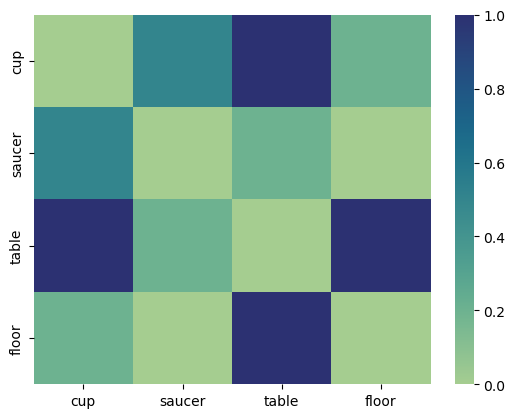

In [2]:
objects = ["cup","saucer","table","floor"]

# counts
cooccur = np.array([[0,5,10,2],
                    [5,0,2,0],
                    [10,2,0,10],
                    [2,0,10,0]])

cooccur = cooccur/np.max(cooccur)

# correlation
# cooccur = np.array([[0,0.9,0.5,0.1],
#                     [0.9,0,0.25,0],
#                     [0.5,0.25,0,0.75],
#                     [0.1,0,0.75,0]])


print(cooccur)
sns.heatmap(cooccur,xticklabels=objects,yticklabels=objects,cmap='crest')

#np.fill_diagonal(cooccur,0)
cooccur = pd.DataFrame(cooccur,index=objects,columns=objects)


In [5]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = objects
edges = list(itertools.combinations(objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

<Axes:>

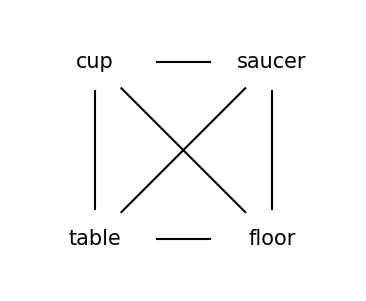

In [6]:
# illustrate graph
pgm = daft.PGM(aspect=2.1, dpi=150, node_unit=1, grid_unit=3, directed=False, node_ec=None)

x = [0, 1, 0, 1]
y = [1, 1, 0, 0]

for i in range(len(nodes)):
    pgm.add_node(nodes[i], nodes[i], x[i], y[i])
    
for i in range(len(edges)):    
    pgm.add_edge(edges[i][0],edges[i][1])
    
pgm.render()

In [7]:
# phi 
def compatibility(edge):
    
    tt = cooccur.loc[edge[0],edge[1]] / np.sum(cooccur.loc[edge[0],:])
    ft = (np.sum(cooccur.loc[:,edge[1]])-cooccur.loc[edge[0],edge[1]]) / (np.sum(np.triu(np.asarray(cooccur)))-np.sum(cooccur.loc[edge[0],:]))
    tf = 1 - tt
    ff = 1 - ft

    phi = [ff, ft, tf, tt]
    
    return phi

In [8]:
# create factors
for edge in G.edges():
    #print(compatibility(edge))
    factor = DiscreteFactor(edge, [2, 2], compatibility(edge))
    G.add_factors(factor)
    
#print(G.edges())
factor.assignment([0,1,2,3])

[[('table', 0), ('floor', 0)],
 [('table', 0), ('floor', 1)],
 [('table', 1), ('floor', 0)],
 [('table', 1), ('floor', 1)]]

In [19]:
# inference
G_infer = VariableElimination(G)
G_prob = G_infer.query(variables=['cup'], evidence={'saucer': 1})
#G_prob = G_infer.query(variables=['saucer'], evidence={'cup': 1})
print(G_prob)

+--------+------------+
| cup    |   phi(cup) |
+========+============+
| cup(0) |     0.0043 |
+--------+------------+
| cup(1) |     0.0783 |
+--------+------------+


In [11]:
gibbs = GibbsSampling(G)

In [15]:
gibbs.sample(size=4)

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\karae\anaconda3\envs\vrrl\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
100%|██████████| 3/3 [00:00<00:00, 1003.50it/s]


,cup,saucer,table,floor
0,0,0,0,1
1,1,0,1,0
2,1,0,0,0
3,1,1,0,0
